## Sentiment Analyzing Models for YouTube Comments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Importing the required packages

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

import re

import nltk
nltk.download('stopwords')
nltk.download("vader_lexicon")
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from keras.preprocessing.sequence import pad_sequences
from nltk.stem.porter import PorterStemmer

import pickle
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from PIL import Image

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pandian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pandian\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Reading the dataset

In [2]:
# data = pd.read_csv("/content/drive/MyDrive/NLP_Data/full_data.csv")
data = pd.read_csv("data/full_data.csv")
data.head()

,video_id,comment_text,likes,replies,comments_preprocessed,compound,sentiment,Negative,Neutral,Positive
0,jt2OHQh0HoQ,It's more accurate to call it the M+ (1000) be...,0,0,accurate M+ 1000 price close call x 10,0.0000,Neutral,0,1,0
1,jt2OHQh0HoQ,To be there with a samsung phone\n😂😂😂,1,0,samsung phone\n 😂 😂 😂,0.0000,Neutral,0,1,0
2,jt2OHQh0HoQ,"Thank gosh, a place I can watch it without hav...",0,0,thank gosh place watch have HD speed support hd,0.6369,Positive,0,0,1
3,jt2OHQh0HoQ,What happened to the home button on the iPhone...,0,0,happen home button iPhone X cough****copying s...,0.0000,Neutral,0,1,0
4,jt2OHQh0HoQ,Power is the disease. Care is the cure. Keep...,0,0,power disease Care cure care well life,0.8176,Positive,0,0,1


In [3]:
data.shape

(104905, 10)

In [4]:
df = data.iloc[:,4:]
df.head()

,comments_preprocessed,compound,sentiment,Negative,Neutral,Positive
0,accurate M+ 1000 price close call x 10,0.0000,Neutral,0,1,0
1,samsung phone\n 😂 😂 😂,0.0000,Neutral,0,1,0
2,thank gosh place watch have HD speed support hd,0.6369,Positive,0,0,1
3,happen home button iPhone X cough****copying s...,0.0000,Neutral,0,1,0
4,power disease Care cure care well life,0.8176,Positive,0,0,1


In [5]:
encoder = LabelEncoder()
df['sentiment_classes'] = encoder.fit_transform(df['sentiment'])

In [6]:
df

,comments_preprocessed,compound,sentiment,Negative,Neutral,Positive,sentiment_classes
0,accurate M+ 1000 price close call x 10,0.0000,Neutral,0,1,0,1
1,samsung phone\n 😂 😂 😂,0.0000,Neutral,0,1,0,1
2,thank gosh place watch have HD speed support hd,0.6369,Positive,0,0,1,2
3,happen home button iPhone X cough****copying s...,0.0000,Neutral,0,1,0,1
4,power disease Care cure care well life,0.8176,Positive,0,0,1,2
...,...,...,...,...,...,...,...
104900,love new house end look amazing wait till fini...,0.8402,Positive,0,0,1,2
104901,trading page proud Emily ♥ 🌹,0.4767,Positive,0,0,1,2
104902,live place Sophie Louise x,0.0000,Neutral,0,1,0,1
104903,live Libby xxx,0.0000,Neutral,0,1,0,1


In [6]:
all_words = ' '.join(df['comments_preprocessed'])
# all_words

In [16]:
def create_wordcloud(text,path):
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
    max_words=1000,
    stopwords=stopwords,
    random_state=42,
    width=900, height=500,
    repeat=True)
    wc.generate(str(text))
    wc.to_file(path)
    print("Word Cloud Saved Successfully")
    path=path
    display(Image.open(path))
    plt.show()

### Visualizing the most frequent words in the comments data

Word Cloud Saved Successfully


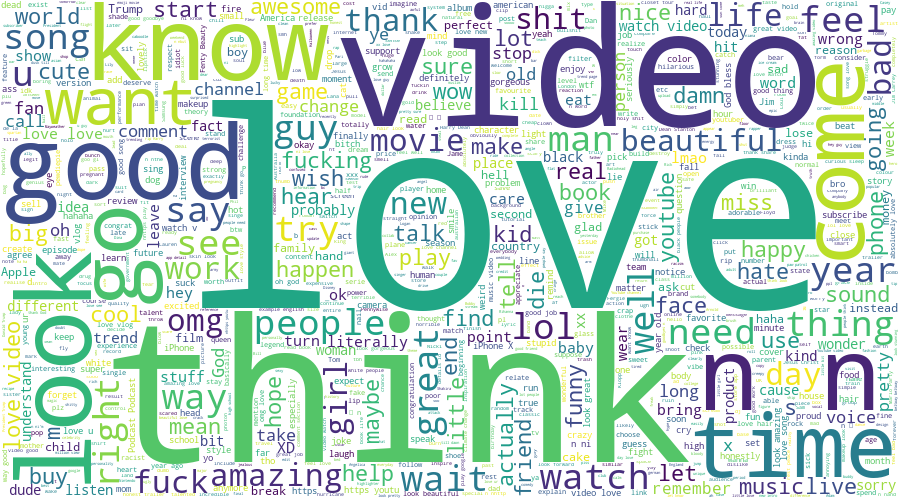

<Figure size 400x640 with 0 Axes>

In [18]:
plt.figure(figsize=(5, 8), dpi=80)
create_wordcloud(all_words,"all_words.png")
plt.show()

In [9]:
# Reducing size due to machine constraints
df = df.iloc[:5000,:]

### Function to analyze the metrics and performance of any model

In [12]:
def model_metrics(X_test,y_test,model,name="mymodel",save_model=False):

  if save_model:
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(np.round(y_pred).astype("int"),axis=1)
    y_test_classes = np.argmax(np.round(y_test[0:5000]).astype("int"),axis=1)
  else:
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred
    y_test_classes = y_test

  print("Accuracy Score:",accuracy_score(y_test_classes,y_pred_classes),end="\n\n")

  cm = confusion_matrix(y_test_classes,y_pred_classes)
  print("Confusion Matrix:\n",cm,end="\n\n")
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

  print("\nClassification Report:\n",classification_report(y_test_classes,y_pred_classes),end="\n\n")

  if save_model:
#     model.save("/content/drive/MyDrive/NLP_Data/{0}.h5".format(name))
    model.save("models_saved/{0}.h5".format(name))

### Preprocessing the data using Keras Tokenizer

In [28]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(df['comments_preprocessed'].values)
X = tokenizer.texts_to_sequences(df['comments_preprocessed'].values)
X = pad_sequences(X)

In [29]:
X.shape

(5000, 191)

In [30]:
X[100]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [31]:
y = df[['Negative','Neutral','Positive']].values
y.shape

(5000, 3)

In [32]:
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.25)

### Building the LSTM model

In [33]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 191, 120)          60000     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 191, 120)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 176)               209088    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 531       
Total params: 269,619
Trainable params: 269,619
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
batch_size=64
history = model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
59/59 [==============================] - 49s 811ms/step - loss: 0.9502 - accuracy: 0.5688
Epoch 2/5
59/59 [==============================] - 49s 834ms/step - loss: 0.7114 - accuracy: 0.7035
Epoch 3/5
59/59 [==============================] - 49s 826ms/step - loss: 0.5243 - accuracy: 0.8187
Epoch 4/5
59/59 [==============================] - 49s 826ms/step - loss: 0.4338 - accuracy: 0.8475
Epoch 5/5
59/59 [==============================] - 49s 839ms/step - loss: 0.3925 - accuracy: 0.8640


In [35]:
X_test.shape

(1250, 191)

In [36]:
model.evaluate(X_test,y_test)

40/40 [==============================] - 4s 84ms/step - loss: 0.5367 - accuracy: 0.7968


[0.5367431640625, 0.7968000173568726]

In [37]:
lstm_model = model

### Performance and metrics of LSTM model

LSTM MODEL:
Accuracy Score: 0.7896

Confusion Matrix:
 [[166  51  38]
 [ 65 318  19]
 [ 37  53 503]]



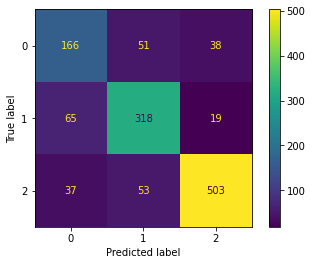


Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.65      0.63       255
           1       0.75      0.79      0.77       402
           2       0.90      0.85      0.87       593

    accuracy                           0.79      1250
   macro avg       0.76      0.76      0.76      1250
weighted avg       0.79      0.79      0.79      1250




In [38]:
print("LSTM MODEL:")
model_metrics(X_test,y_test,model=lstm_model,name="lstm_model_scratch_79_68",save_model=True)

### It gives an accuracy of 78.96%

In [39]:
ps = PorterStemmer()
corpus = []
words = []
for i in range(0,len(df)):
    comment = re.sub('[^a-zA-Z0-9]',' ',df['comments_preprocessed'][i])
    comment = comment.lower()
    comment = comment.split()
    comment = [ps.stem(word) for word in comment if not word in stopwords.words('english')]
    statements = ' '.join(comment)
    corpus.append(statements)
    words.append(comment)

### Preprocessing the data using CountVectorizer

In [40]:
count = CountVectorizer(max_features=5000,ngram_range=(1,3))
X_count = count.fit_transform(corpus).toarray()
print(X_count.shape)

(5000, 5000)


In [41]:
count.get_feature_names()[-10:]

['youtub video',
 'ysac',
 'yt',
 'yummi',
 'zero',
 'zinc',
 'zip',
 'zoe',
 'zoe zoe',
 'zont']

In [42]:
y = df['sentiment_classes']
y

0       1
1       1
2       2
3       1
4       2
       ..
4995    1
4996    2
4997    1
4998    2
4999    1
Name: sentiment_classes, Length: 5000, dtype: int32

In [43]:
X_train_count,X_test_count,y_train_count,y_test_count = train_test_split(X_count,y,test_size=0.3)

### Defining the Logistic Regression machine learning model

In [44]:
lr = LogisticRegression(multi_class='multinomial')
lr.fit(X_train_count,y_train_count)

LogisticRegression(multi_class='multinomial')

### Performance and Metrics of Logistic Regression model

LOGISTIC REGRESSION:
Accuracy Score: 0.8393333333333334

Confusion Matrix:
 [[162  80  38]
 [ 11 474  19]
 [ 27  66 623]]



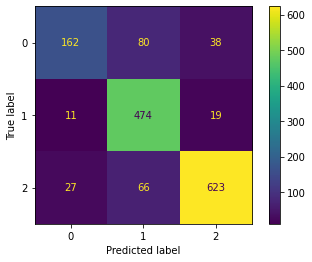


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.58      0.67       280
           1       0.76      0.94      0.84       504
           2       0.92      0.87      0.89       716

    accuracy                           0.84      1500
   macro avg       0.83      0.80      0.80      1500
weighted avg       0.85      0.84      0.84      1500




In [45]:
print("LOGISTIC REGRESSION:")
model_metrics(X_test_count,y_test_count,model=lr)

### It gives an accuracy of 83.93%

In [46]:
# model_filename = "/content/drive/MyDrive/NLP_Data/models/lr_model.sav"
model_filename = "models_saved/lr_model_83_93.sav"
saved_model = pickle.dump(lr, open(model_filename,'wb'))
print('Model is saved into to disk successfully Using Pickle')

Model is saved into to disk successfully Using Pickle


### Preprocessing the data using TfidfVectorizer

In [47]:
tfidf = TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X_tfidf = tfidf.fit_transform(corpus).toarray()

In [48]:
X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf = train_test_split(X_tfidf,y,test_size=0.3)

### Training the Multinomial Naive Bayes Classifier

In [49]:
mn = MultinomialNB(alpha=0.1)
mn.fit(X_train_tfidf,y_train_tfidf)

MultinomialNB(alpha=0.1)

### Performance and Metrics of Multinomial Naive Bayes Classifier

MULTINOMIAL NAIVEBAYES
Accuracy Score: 0.6666666666666666

Confusion Matrix:
 [[172  37  87]
 [ 33 231 229]
 [ 51  63 597]]



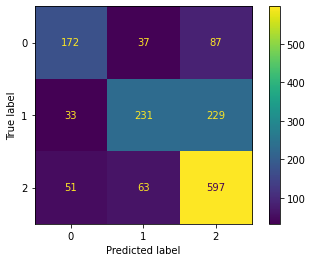


Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.58      0.62       296
           1       0.70      0.47      0.56       493
           2       0.65      0.84      0.74       711

    accuracy                           0.67      1500
   macro avg       0.67      0.63      0.64      1500
weighted avg       0.67      0.67      0.66      1500




In [50]:
print("MULTINOMIAL NAIVEBAYES")
model_metrics(X_test_tfidf,y_test_tfidf,model=mn)

### It gives an accuracy of 66.67%

In [51]:
# model_filename = "/content/drive/MyDrive/NLP_Data/models/mn_model.sav"
model_filename = "models_saved/mn_model_67_66.sav"
saved_model = pickle.dump(mn, open(model_filename,'wb'))
print('Model is saved into to disk successfully Using Pickle')

Model is saved into to disk successfully Using Pickle


### The sentiments are encoded as follows
### 0 - Negative
### 1 - Neutral
### 2 - Positive

### Finding the sentiments using SentimentIntensityAnalyzer

In [53]:
s = SentimentIntensityAnalyzer()
y_pred = []
sentiment = 0
for comment in df['comments_preprocessed']:
  compound = s.polarity_scores(comment)['compound']
  if compound > 0:
    sentiment = 2
  elif compound < 0:
    sentiment = 0
  else:
    sentiment = 1
  y_pred.append(sentiment)

In [54]:
y_pred[0:10]

[1, 1, 2, 1, 2, 2, 2, 0, 0, 2]

In [55]:
y[0:10]

0    1
1    1
2    2
3    1
4    2
5    2
6    2
7    0
8    0
9    2
Name: sentiment_classes, dtype: int32

### Performance and Metrics of SentimentIntensityAnalyzer

Accuracy Score: 1.0

Confusion Matrix:
 [[ 954    0    0]
 [   0 1655    0]
 [   0    0 2391]]



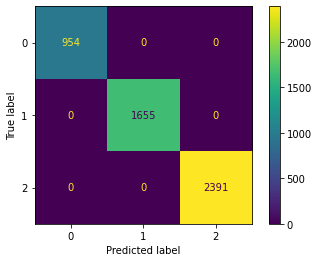


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00      1655
           2       1.00      1.00      1.00      2391

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000




In [56]:
print("Accuracy Score:",accuracy_score(y,y_pred),end="\n\n")

cm = confusion_matrix(y,y_pred)
print("Confusion Matrix:\n",cm,end="\n\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print("\nClassification Report:\n",classification_report(y,y_pred),end="\n\n")

### It gives an accuracy of 100%